## Initial Setup

In [1]:
import torch
import matplotlib.pyplot as plt

from vap.events.events import TurnTakingEvents, EventConfig
from vap.modules.lightning_module import VAPModule
from vap.data.datamodule import VAPDataset
from vap.utils.plot import plot_melspectrogram, plot_vad, plot_vap_probs

In [2]:
def plot_output(d, out):
    # Define the ratios for the subplot heights
    height_ratios = [2, 2, 1, 1, 1, 1]

    # Create the figure and the GridSpec instance with the given height ratios
    fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(15, 6), gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.01})

    plot_melspectrogram(d["waveform"], ax=ax[:2])
    # plot vad.
    # VAD is by default longer than the audio (for prediction)
    # See zeros at the end of the waveforms where the VAD is defined but the audio is not.
    x = torch.arange(d["vad"].shape[0]) / dset.frame_hz
    x2 = torch.arange(out["vad"].shape[1]) / dset.frame_hz
    plot_vad(x, d["vad"][:, 0], ax[0], ypad=3, color="b", label="VAD A")
    plot_vad(x, d["vad"][:, 1], ax[1], ypad=3, color="orange", label="VAD A")
    plot_vad(x2, out["vad"][0, :, 0], ax[0], ypad=3, color="w", label="VAD pred")
    plot_vad(x2, out["vad"][0, :, 1], ax[1], ypad=3, color="w", label="VAD pred")
    for i in range(4):
        plot_vap_probs(out['p'][i, 0], ax=ax[2+i])
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].legend()
    ax[1].legend()
    ax[-1].set_xticks(list(range(0, 1+round(x[-1].item())))) #list(range(0, 20)))
    ax[-1].set_xlabel("Time (s)")
    return fig, ax

In [3]:
def plot_event(evnt, ax, frame_hz=50):
    for shift in evnt:
        start = shift[0] / frame_hz
        end = shift[1] / frame_hz
        ch = shift[2]
        for aa in ax:
            aa.axvline(start, color='r')
            aa.axvline(end, color='r', linestyle='dashed')
        print("start: ", start)
        print("end: ", end)
        print("channel: ", ch)

In [4]:
CSV_PATH = "/home/erik/projects/CCConv/VoiceActivityProjection/data/splits/fis_swb/val_sliding.csv"
dset = VAPDataset(CSV_PATH)
print('Dataset: ', len(dset))

Dataset:  16100


In [5]:
df = dset.df

In [6]:
df['audio_path'] = df['audio_path'].apply(lambda x: x.replace('..', '/home/ubuntu'))

In [7]:
dset.df = df

## Serhan - Audio Augmented Model - 1

In [8]:
CHECKPOINT_PATH = "/home/serhan/Desktop/VoiceActivityProjection/serhan-utils/checkpoints/audio_1/epoch=0-step=10880.ckpt"
module = VAPModule.load_from_checkpoint(CHECKPOINT_PATH)
model = module.model
model.to('cuda')

/home/serhan/miniconda3/envs/cleanvap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


VAP(
  (encoder): EncoderCPC(
    (encoder): CPCModel(
      (gEncoder): CPCEncoder(
        (conv0): Conv1d(1, 256, kernel_size=(10,), stride=(5,), padding=(3,))
        (batchNorm0): ChannelNorm()
        (conv1): Conv1d(256, 256, kernel_size=(8,), stride=(4,), padding=(2,))
        (batchNorm1): ChannelNorm()
        (conv2): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm2): ChannelNorm()
        (conv3): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm3): ChannelNorm()
        (conv4): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm4): ChannelNorm()
      )
      (gAR): CPCAR(
        (baseNet): LSTM(256, 256, batch_first=True)
      )
    )
    (downsample): Sequential(
      (0): Rearrange('b t d -> b d t')
      (1): CConv1d(
        256, 256, kernel_size=(5,), stride=(2,)
        (pad): ConstantPad1d(padding=(4, 0), value=0)
      )
      (2): LayerNorm((256,), eps=1e-05, elementw

In [9]:
conf = EventConfig(
    metric_time=0.05,
    equal_hold_shift=False,
    sh_pre_cond_time=0.5,
    sh_post_cond_time=0.5,
)
eventer = TurnTakingEvents(conf)

In [10]:
row = torch.randint(0, len(dset), (1,)).item()

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])


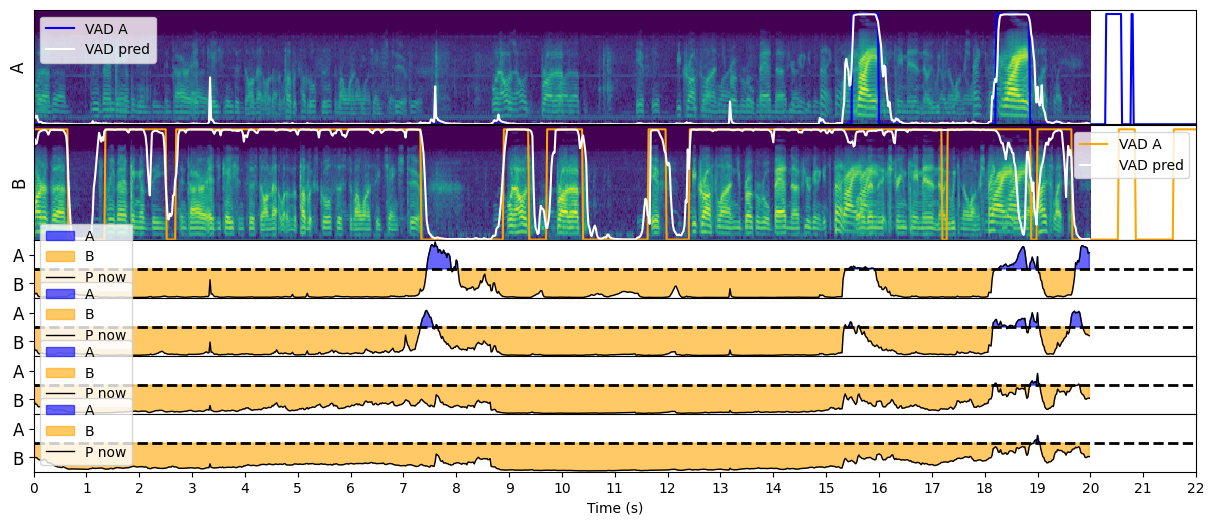

In [11]:
d = dset[row]
out = model.probs(d['waveform'].unsqueeze(0).to('cuda'))
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])


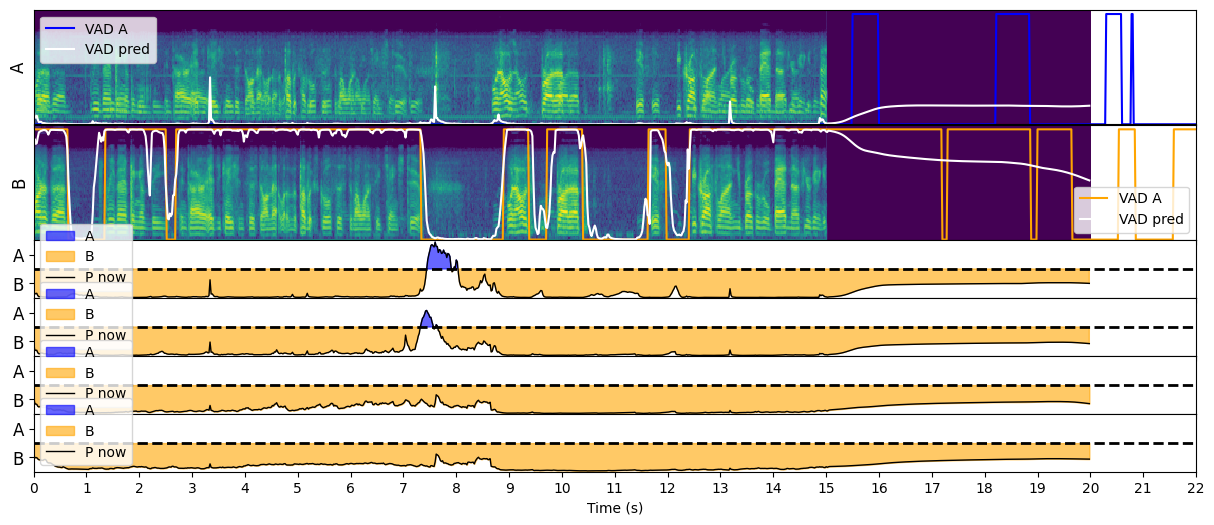

In [12]:
# Mask in the middle
x_masked = d['waveform']
start, end = int(dset.sample_rate * 15), int(dset.sample_rate * 20)
x_masked[:, start:end] = 0
out = model.probs(x_masked.unsqueeze(0).to('cuda'))
d['waveform'] = x_masked
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

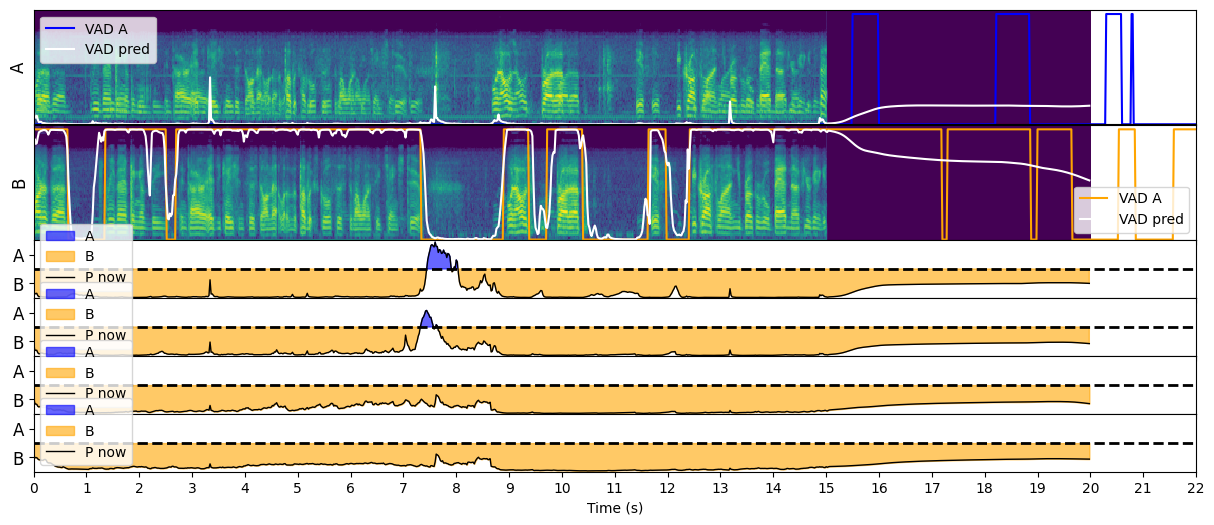

In [13]:
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

## Serhan - Initial Checkpoint

In [33]:
CHECKPOINT_PATH = "/home/serhan/Desktop/VoiceActivityProjection/checkpoints/serhan_checkpoints/sink_1/checkpoint.ckpt"
module = VAPModule.load_from_checkpoint(CHECKPOINT_PATH)
model = module.model
model.to('cuda')

/home/serhan/miniconda3/envs/vap-clean/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


VAP(
  (encoder): EncoderCPC(
    (encoder): CPCModel(
      (gEncoder): CPCEncoder(
        (conv0): Conv1d(1, 256, kernel_size=(10,), stride=(5,), padding=(3,))
        (batchNorm0): ChannelNorm()
        (conv1): Conv1d(256, 256, kernel_size=(8,), stride=(4,), padding=(2,))
        (batchNorm1): ChannelNorm()
        (conv2): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm2): ChannelNorm()
        (conv3): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm3): ChannelNorm()
        (conv4): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm4): ChannelNorm()
      )
      (gAR): CPCAR(
        (baseNet): LSTM(256, 256, batch_first=True)
      )
    )
    (downsample): Sequential(
      (0): Rearrange('b t d -> b d t')
      (1): CConv1d(
        256, 256, kernel_size=(5,), stride=(2,)
        (pad): ConstantPad1d(padding=(4, 0), value=0)
      )
      (2): LayerNorm((256,), eps=1e-05, elementw

In [34]:
conf = EventConfig(
    metric_time=0.05,
    equal_hold_shift=False,
    sh_pre_cond_time=0.5,
    sh_post_cond_time=0.5,
)
eventer = TurnTakingEvents(conf)

In [35]:
row = torch.randint(0, len(dset), (1,)).item()

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  6.32
end:  6.58
channel:  0
start:  3.6
end:  4.92
channel:  1
start:  12.82
end:  13.46
channel:  1


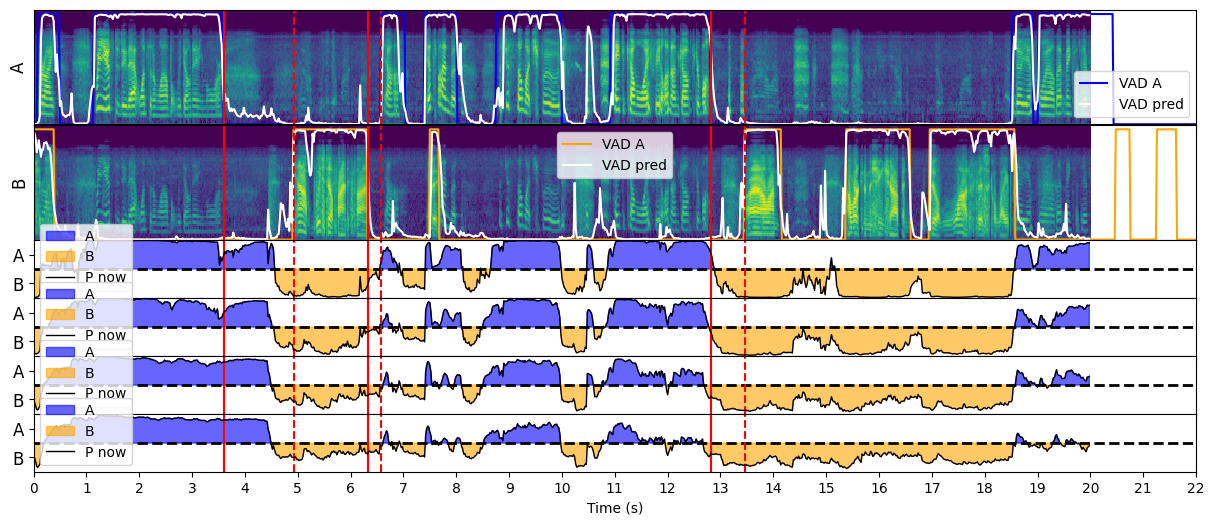

In [36]:
d = dset[row]
out = model.probs(d['waveform'].unsqueeze(0).to('cuda'))
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  6.32
end:  6.58
channel:  0
start:  3.6
end:  4.92
channel:  1
start:  12.82
end:  13.46
channel:  1


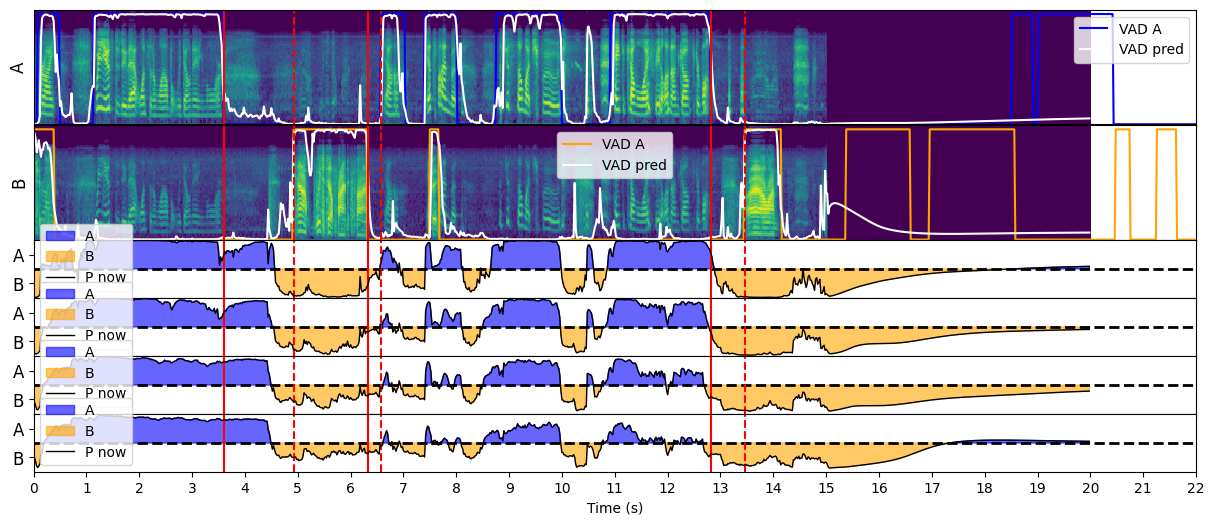

In [37]:
# Mask in the middle
x_masked = d['waveform']
start, end = int(dset.sample_rate * 15), int(dset.sample_rate * 20)
x_masked[:, start:end] = 0
out = model.probs(x_masked.unsqueeze(0).to('cuda'))
d['waveform'] = x_masked
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

start:  6.32
end:  6.58
channel:  0
start:  3.6
end:  4.92
channel:  1
start:  12.82
end:  13.46
channel:  1


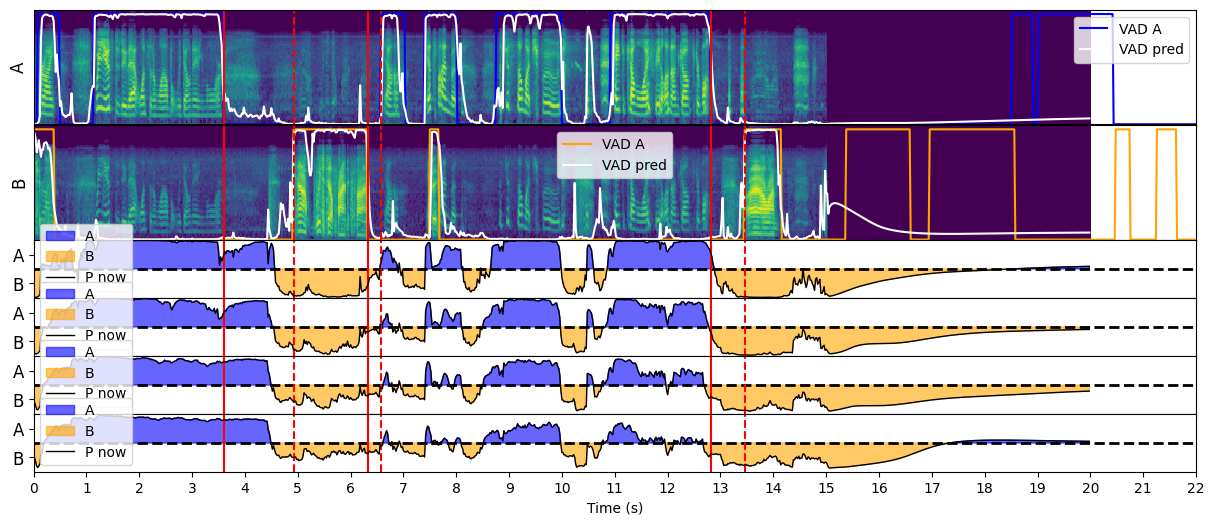

In [38]:
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

## Erik's last checkpoint

In [12]:
CHECKPOINT_PATH = "/home/serhan/Desktop/VoiceActivityProjection/checkpoints/erik_checkpoints/checkpoint.ckpt"
module = VAPModule.load_from_checkpoint(CHECKPOINT_PATH)
model = module.model
model.to('cuda')

/home/serhan/miniconda3/envs/vap-clean/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


VAP(
  (encoder): EncoderCPC(
    (encoder): CPCModel(
      (gEncoder): CPCEncoder(
        (conv0): Conv1d(1, 256, kernel_size=(10,), stride=(5,), padding=(3,))
        (batchNorm0): ChannelNorm()
        (conv1): Conv1d(256, 256, kernel_size=(8,), stride=(4,), padding=(2,))
        (batchNorm1): ChannelNorm()
        (conv2): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm2): ChannelNorm()
        (conv3): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm3): ChannelNorm()
        (conv4): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
        (batchNorm4): ChannelNorm()
      )
      (gAR): CPCAR(
        (baseNet): LSTM(256, 256, batch_first=True)
      )
    )
    (downsample): Sequential(
      (0): Rearrange('b t d -> b d t')
      (1): CConv1d(
        256, 256, kernel_size=(5,), stride=(2,)
        (pad): ConstantPad1d(padding=(4, 0), value=0)
      )
      (2): LayerNorm((256,), eps=1e-05, elementw

In [13]:
conf = EventConfig(
    metric_time=0.05,
    equal_hold_shift=False,
    sh_pre_cond_time=0.5,
    sh_post_cond_time=0.5,
)
eventer = TurnTakingEvents(conf)

In [14]:
row = torch.randint(0, len(dset), (1,)).item()

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])


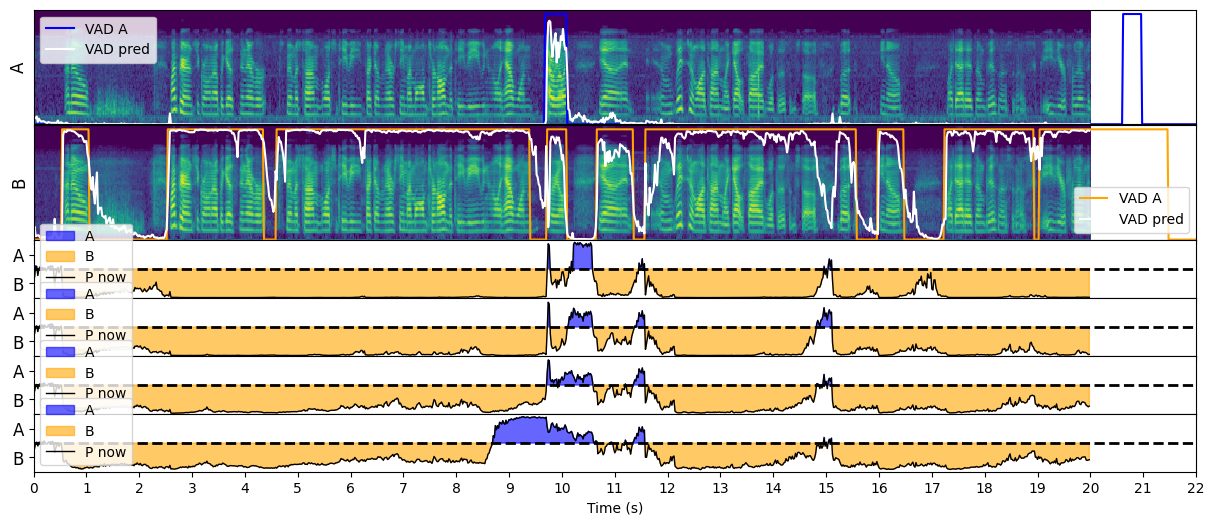

In [15]:
d = dset[row]
out = model.probs(d['waveform'].unsqueeze(0).to('cuda'))
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])


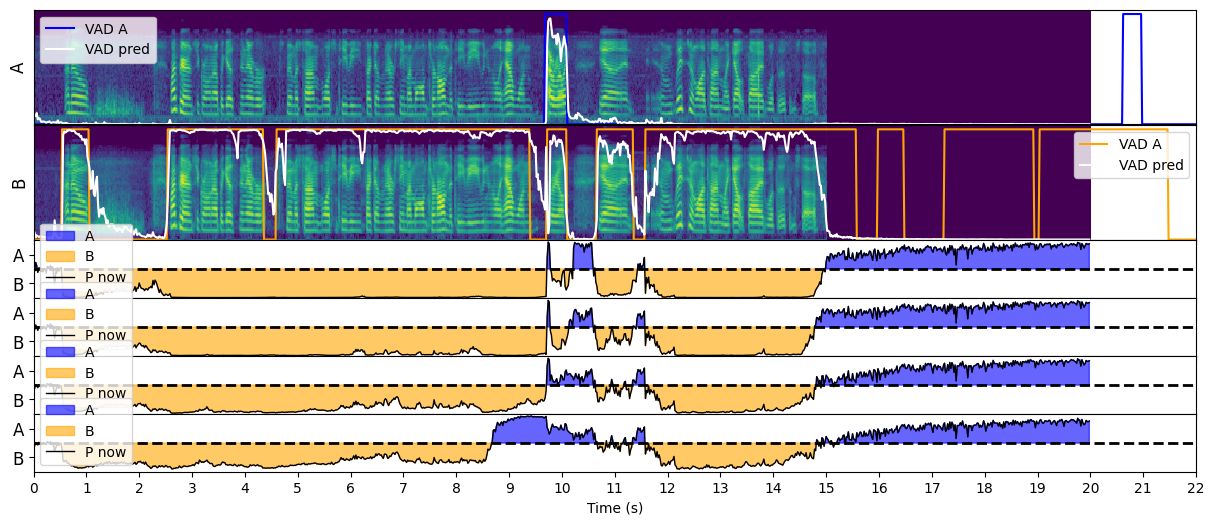

In [16]:
# Mask in the middle
x_masked = d['waveform']
start, end = int(dset.sample_rate * 15), int(dset.sample_rate * 20)
x_masked[:, start:end] = 0
out = model.probs(x_masked.unsqueeze(0).to('cuda'))
d['waveform'] = x_masked
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

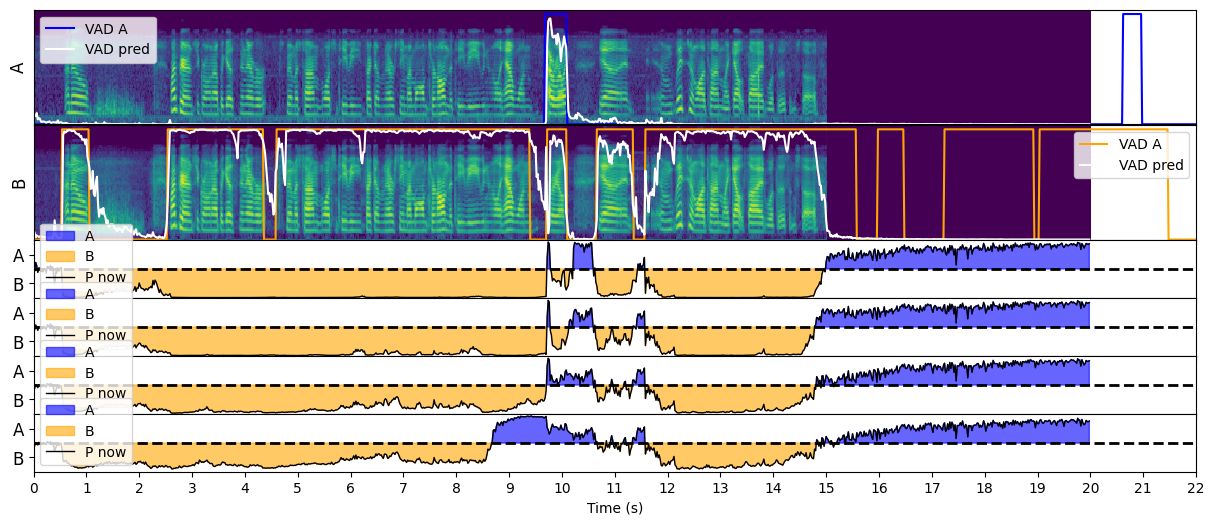

In [17]:
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)